In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from wavhandler import *
from utils import *

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')

# Creating dataframes that contain PSDs for each insect class

In [3]:
sz = 500
df_an = make_df_parallel(df_mosquitos, setting='psd', insect_class='Anopheles', sample_size=sz).T
df_an['label'] = 'an'
df_ae = make_df_parallel(df_mosquitos, setting='psd',insect_class='Aedes', sample_size=sz).T
df_ae['label'] = 'ae'
df_cu = make_df_parallel(df_mosquitos, setting='psd',insect_class='Culex', sample_size=sz).T
df_cu['label'] = 'cu'

/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child processes.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child processes.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child processes.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child p

In [4]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='any', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(labelarray.shape)

(1500, 130)
(1500, 130)
(1500,)


### Example PSD

In [5]:
# df_concat.iloc[9,:-1].plot()

## Principal Component Analysis (traditional)

In [6]:
from sklearn.preprocessing import StandardScaler

X = df_concat.iloc[:,:-1].values

idx = np.random.randint(X.shape[0], size=3000)
X = X[idx,:]

labelarray = labelarray[idx]
y = labelarray

X_std = StandardScaler(with_std=False).fit_transform(X)

mean_vec = np.mean(X_std, axis=0)

cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix 
[[7.05897896e-09 6.69500292e-09 4.07217153e-09 ... 2.55892626e-12
  2.53576666e-12 2.52470742e-12]
 [6.69500292e-09 8.26110880e-09 1.87080897e-08 ... 2.25192008e-12
  2.19863759e-12 2.18291930e-12]
 [4.07217153e-09 1.87080897e-08 1.19077699e-07 ... 1.02517216e-12
  7.12074005e-13 6.57607245e-13]
 ...
 [2.55892626e-12 2.25192008e-12 1.02517216e-12 ... 1.23419824e-13
  1.20112776e-13 1.19323698e-13]
 [2.53576666e-12 2.19863759e-12 7.12074005e-13 ... 1.20112776e-13
  1.17296673e-13 1.16510663e-13]
 [2.52470742e-12 2.18291930e-12 6.57607245e-13 ... 1.19323698e-13
  1.16510663e-13 1.15749472e-13]]
NumPy covariance matrix: 
[[7.05897896e-09 6.69500292e-09 4.07217153e-09 ... 2.55892626e-12
  2.53576666e-12 2.52470742e-12]
 [6.69500292e-09 8.26110880e-09 1.87080897e-08 ... 2.25192008e-12
  2.19863759e-12 2.18291930e-12]
 [4.07217153e-09 1.87080897e-08 1.19077699e-07 ... 1.02517216e-12
  7.12074005e-13 6.57607245e-13]
 ...
 [2.55892626e-12 2.25192008e-12 1.02517216e-12 ... 1.

In [7]:
u,s,v = np.linalg.svd(X_std.T)
print(u)
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for q,i in enumerate(eig_pairs):
    print(i[0])
    if q>10:
        break

[[ 1.15503772e-04 -5.08711630e-05  1.30068062e-05 ... -1.64089653e-05
  -5.07556183e-05 -1.78065983e-05]
 [ 1.00736838e-04 -4.78031914e-05  1.40304727e-05 ...  4.59063575e-05
   5.16296976e-05  1.98459519e-05]
 [-2.37793361e-06 -2.24501312e-05  1.13637324e-05 ... -5.34699018e-05
  -1.76109914e-05 -4.51016799e-06]
 ...
 [-6.52328766e-08  5.53055403e-08 -3.28761214e-08 ...  5.08539343e-01
   7.06832433e-01 -1.49472812e-01]
 [-6.01352623e-08  4.88683222e-08 -3.21363298e-08 ...  2.01194710e-01
  -5.94228295e-01 -6.08605599e-01]
 [-5.92327398e-08  4.82790891e-08 -3.14974633e-08 ...  2.34650937e-01
  -3.23363829e-01  7.79015180e-01]]
Everything ok!
Eigenvalues in descending order:
0.14583801250466677
0.11066506322002209
0.08195616994304944
0.07592653592863195
0.05135996096301426
0.04732555185803517
0.03606925580495032
0.03081867610378408
0.028077680958272327
0.01931151717617064
0.018756554359285995
0.017174893973726357


In [8]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp = cum_var_exp[:10]
var_exp = var_exp[:10]

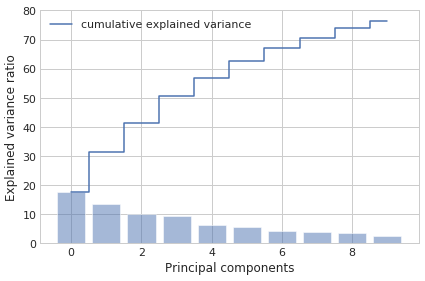

In [9]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), np.array(var_exp), alpha=0.5)
    plt.step(range(len(var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [10]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(128,1),
                      eig_pairs[1][1].reshape(128,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-1.15503772e-04 -5.08711630e-05]
 [-1.00736838e-04 -4.78031914e-05]
 [ 2.37793361e-06 -2.24501312e-05]
 [ 8.26840360e-06 -3.49141493e-05]
 [-2.08471847e-05 -2.67264864e-05]
 [-3.27636209e-05 -6.58297412e-05]
 [-6.92704341e-05 -5.66316921e-05]
 [-7.42370307e-05  5.00924328e-05]
 [-4.19750019e-05  2.27304325e-04]
 [-2.08184836e-04  4.20040305e-04]
 [-8.48443933e-04  7.46516814e-04]
 [-4.33125918e-03  5.26467198e-03]
 [-2.90395677e-02  4.21269204e-02]
 [-1.65225091e-01  1.25228224e-01]
 [-4.37023156e-01  6.47852553e-02]
 [-4.78826329e-01 -1.97295726e-01]
 [-1.91624892e-01 -3.11575363e-01]
 [ 7.83117195e-02 -3.10391993e-01]
 [ 2.05153049e-01 -2.70737386e-01]
 [ 2.03297735e-01 -1.53732449e-01]
 [ 1.63936940e-01 -6.29445809e-02]
 [ 1.17137007e-01 -4.83514335e-03]
 [ 1.02163505e-01  3.77301755e-02]
 [ 9.24407390e-02  8.10307759e-02]
 [ 8.90366465e-02  1.55372358e-01]
 [ 8.37605051e-02  2.94482111e-01]
 [ 2.68055067e-02  3.97899686e-01]
 [-9.65511631e-02  3.62874867e-01]
 [-2.2742

In [11]:
Y = X_std.dot(matrix_w)

In [12]:
np.unique(y)

array(['ae', 'an', 'cu'], dtype=object)

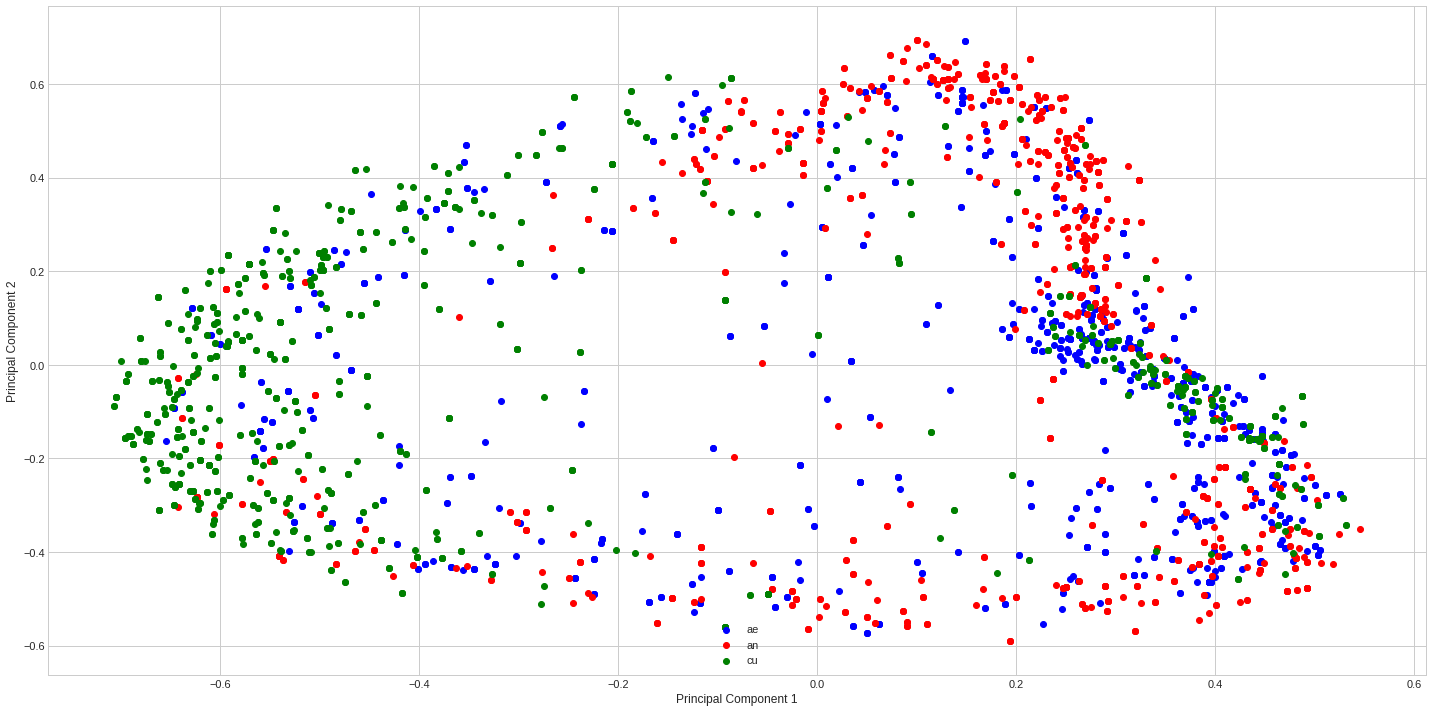

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20, 10))
    for lab, col in zip(('ae', 'an', 'cu'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [14]:
Y

array([[ 0.25875998,  0.46221415],
       [ 0.31555419,  0.03631953],
       [-0.49334054,  0.22980097],
       ...,
       [ 0.37639639, -0.32375332],
       [-0.54407058, -0.07186294],
       [-0.62546029,  0.08010501]])

# Principal Component Analysis (short)

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_concat.iloc[:,:-1].values
idx = np.random.randint(X.shape[0], size=3000)
X = X[idx,:]
labelarray = labelarray[idx]
X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data

ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
Χ_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

plt.figure(figsize=(10,8))
sns.scatterplot(Χ_final[:,0], Χ_final[:,1], hue=labelarray, style=labelarray, alpha=0.9)
plt.xlabel('component 1')
plt.ylabel('component 2')

EXPLAINED VARIANCE with 2 components: 0.34


In [91]:
df_pca = pd.DataFrame(pca.components_,index = ['PC-1','PC-2'])#, 'PC-3'])
df_pca

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
PC-1,0.000115,0.000108,0.000184,0.000747,0.001134,0.000745,0.000454,0.000379,0.000295,0.0005,...,-2.282069e-08,-2.146093e-08,-2.110493e-08,-2.021947e-08,-1.957447e-08,-1.908503e-08,-1.868154e-08,-1.835962e-08,-1.813648e-08,-1.800157e-08
PC-2,-0.000028,-0.000009,0.000139,0.000407,0.000531,0.000621,0.000611,0.000538,0.000515,0.0006,...,5.441365e-08,5.378476e-08,5.267317e-08,5.199374e-08,5.124892e-08,5.072738e-08,5.024313e-08,4.990112e-08,4.964876e-08,4.949870e-08


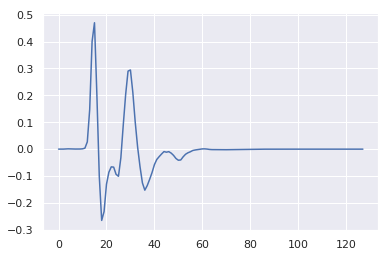

In [93]:
df_pca.loc['PC-1'].plot()

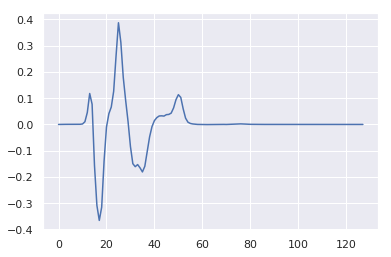

In [94]:
df_pca.loc['PC-2'].plot()

In [95]:
#df_pca.loc['PC-3'].plot()

# 3D Plot (PCA scores, 3 components)

In [14]:
import plotly
import plotly.plotly as py
from sklearn.preprocessing import LabelEncoder
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color=LabelEncoder().fit(['cu','an','ae']).transform(labelarray),#'rgba(217, 217, 217, 0.14)',
            colorscale='Portland',
            width=0.5
        ),
        opacity=0.7
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(Χ_final)


import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color=kmeans.labels_,#'rgba(217, 217, 217, 0.14)',
            colorscale='Viridis',
            width=0.5
        ),
        opacity=0.9
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# Edw eisai

In [ ]:
df_an = df_an.transpose()
df_an.shape

In [ ]:
df_an['kmeans'] = kmeans.labels_

In [ ]:
df_an.sample(10)

In [ ]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(df_an['kmeans'].to_dict(), 'df_an_clusters')